In [1]:
# Прогнозирование возможной смены работы
# Постановка задачи:
# Компания, занимающаяся большими данными и наукой о данных, хочет нанять специалистов по данным из числа людей, успешно прошедших курсы, проводимые компанией. Многие люди записываются на обучение. Компания хочет знать, кто из этих кандидатов действительно хочет работать в компании после обучения или ищет новую работу, потому что это помогает снизить затраты и время, а также качество обучения или планирование курсов и категоризацию кандидатов . Информация, связанная с демографическими данными, образованием, опытом, поступает от кандидатов при регистрации и зачислении.
# Этот набор данных разработан, чтобы понять факторы, которые заставляют человека бросить текущую работу, чтобы заняться HR-исследованиями. С помощью модели (моделей), в которой используются текущие учетные данные, демографические данные и данные об опыте, вы можете предсказать вероятность того, что кандидат будет искать новую работу или будет работать в компании, а также интерпретируете затронутые факторы при принятии решения сотрудником.
# Описание структуры данных  доступно по ссылке:
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv
import pandas as pd
df = pd.read_csv('aug_train.csv')

In [6]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
# Важно импортировать Pipeline из imblearn для поддержки SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Загрузка и изучение данных
df = pd.read_csv('aug_train.csv')
print("Размер данных:", df.shape)
print("\nПервые 5 строк данных:")
print(df.head())

# Анализ пропущенных значений
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Values': missing_values,
    'Percent': missing_percent
}).sort_values('Missing_Values', ascending=False)
print("\nПропущенные значения:")
print(missing_df[missing_df['Missing_Values'] > 0])

# Проверка распределения целевой переменной
target_counts = df['target'].value_counts(normalize=True) * 100
print("\nРаспределение целевой переменной:")
print(f"Не ищут новую работу: {target_counts[0]:.2f}%")
print(f"Ищут новую работу: {target_counts[1]:.2f}%")

Размер данных: (19158, 14)

Первые 5 строк данных:
   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99     

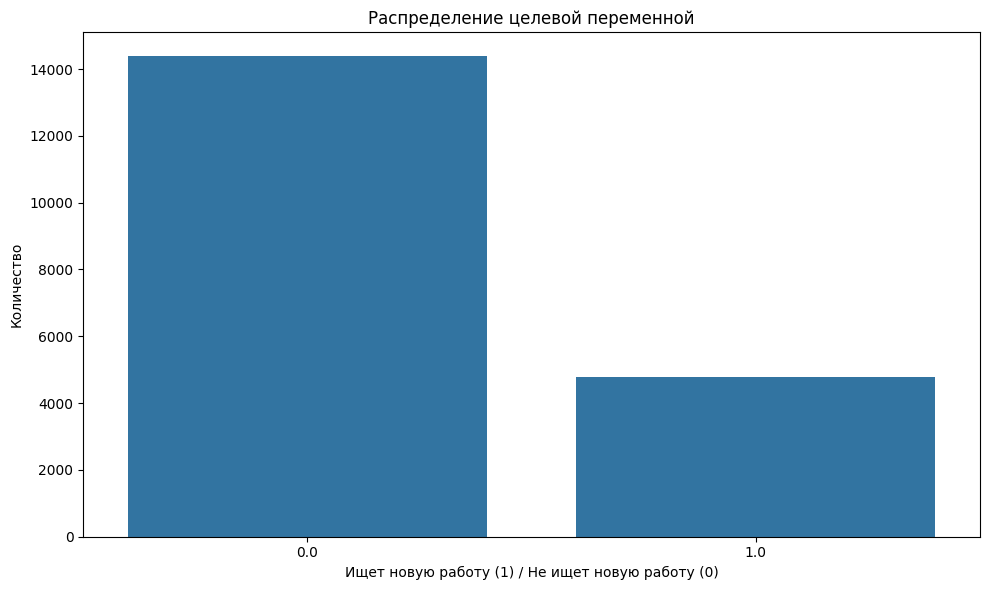

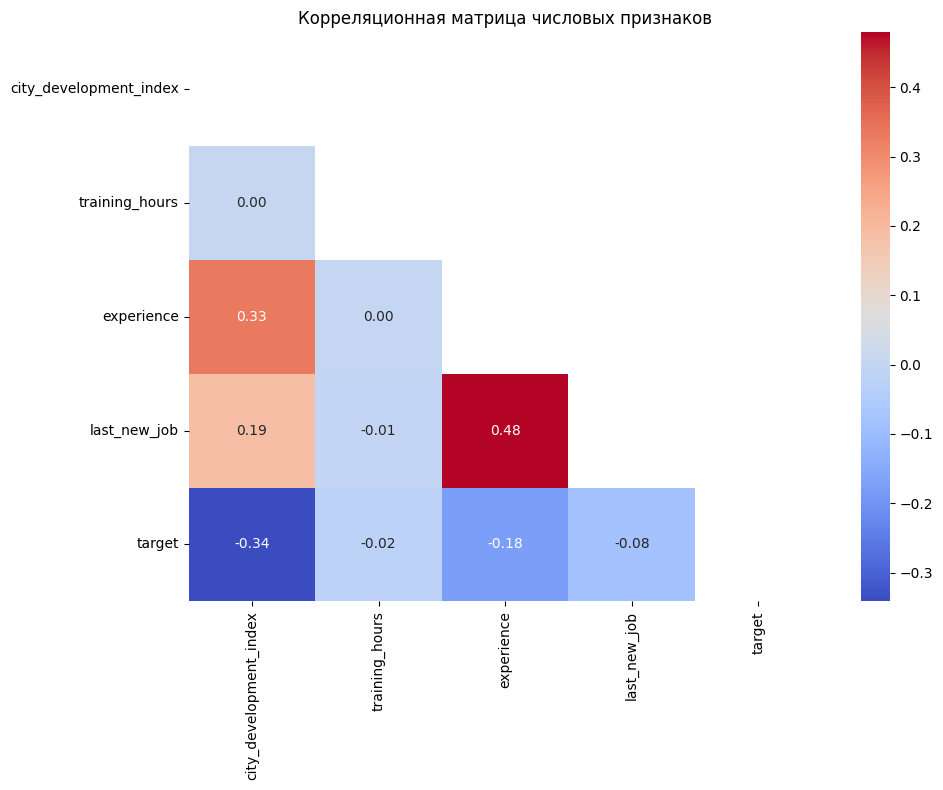

In [7]:
# Предобработка данных
# Удаление идентификатора
df = df.drop('enrollee_id', axis=1)

# Обработка столбца experience
def clean_experience(x):
    if pd.isna(x):
        return x
    elif x == '<1':
        return 0.5
    elif x == '>20':
        return 21
    else:
        return float(x)

df['experience'] = df['experience'].apply(clean_experience)

# Обработка столбца last_new_job
def clean_last_new_job(x):
    if pd.isna(x):
        return x
    elif x == 'never':
        return 0
    elif x == '>4':
        return 5
    else:
        return float(x)

df['last_new_job'] = df['last_new_job'].apply(clean_last_new_job)

# Визуализация данных
# Распределение целевой переменной
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df)
plt.title('Распределение целевой переменной')
plt.xlabel('Ищет новую работу (1) / Не ищет новую работу (0)')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

# Корреляция числовых признаков
numeric_features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']
plt.figure(figsize=(10, 8))
corr = df[numeric_features + ['target']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

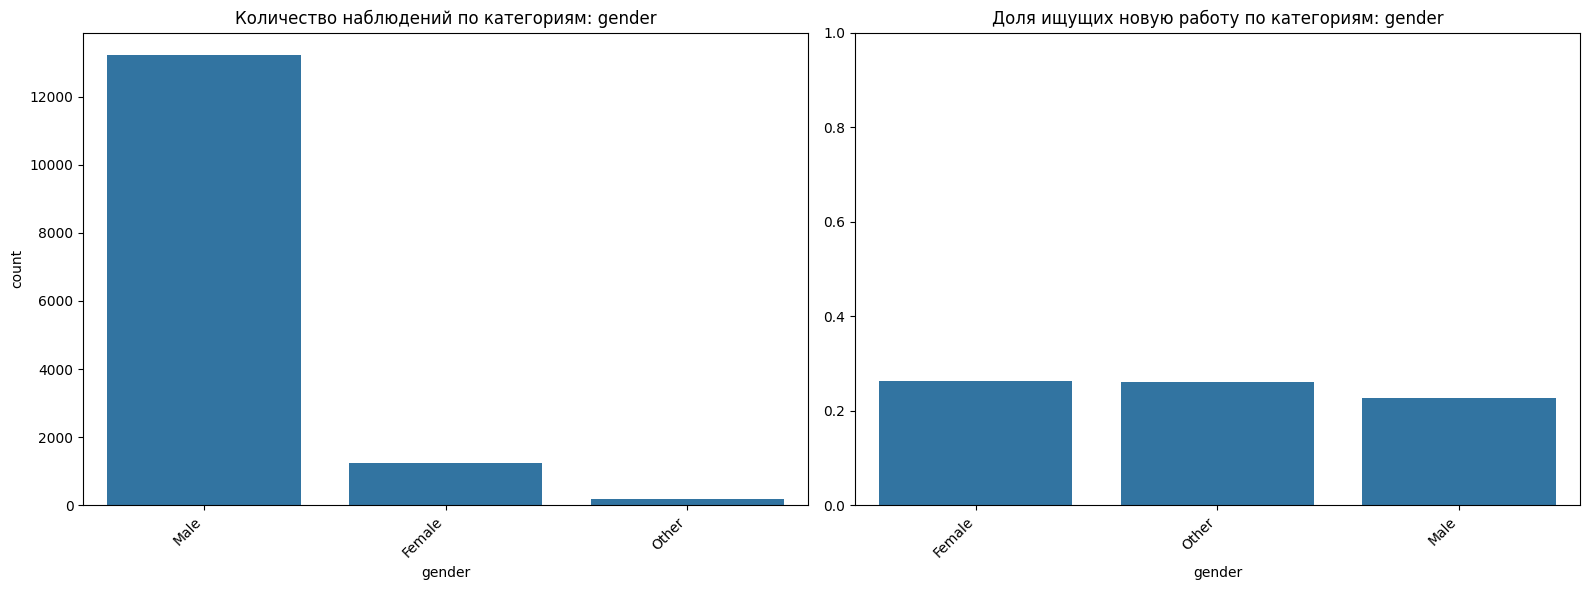

<Figure size 1200x600 with 0 Axes>

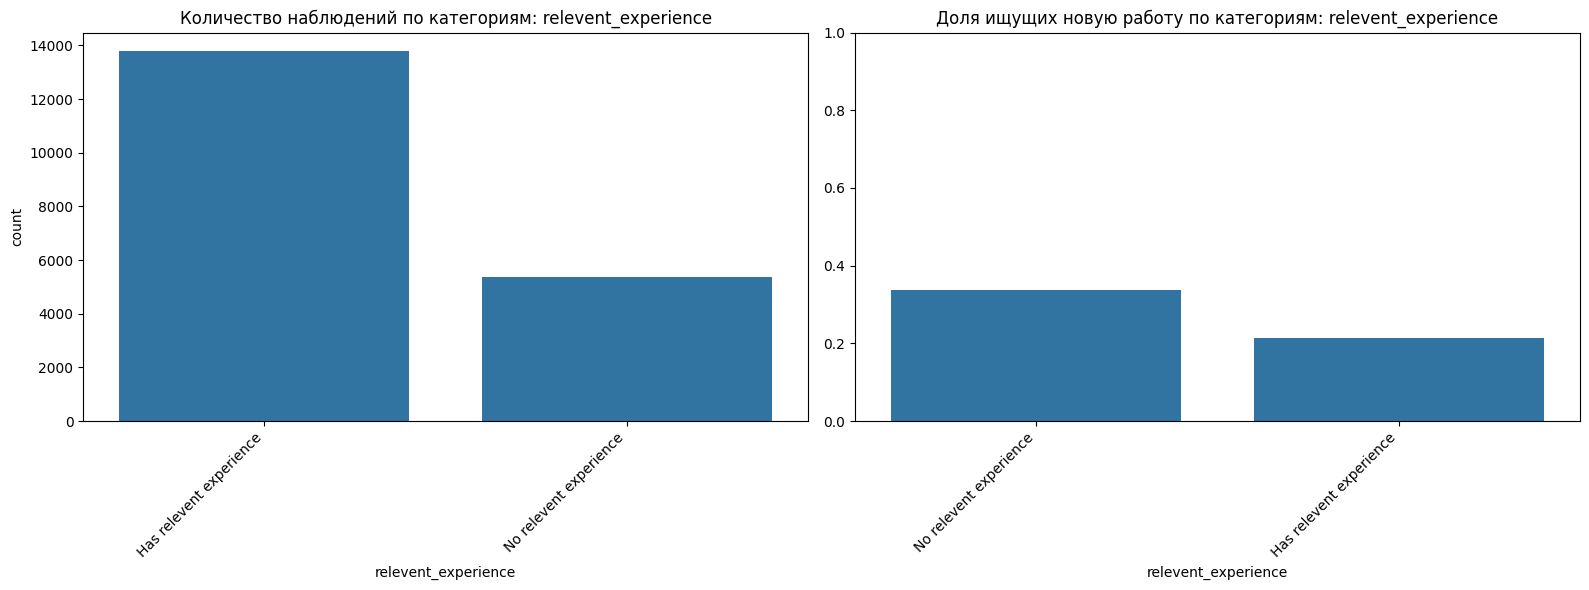

<Figure size 1200x600 with 0 Axes>

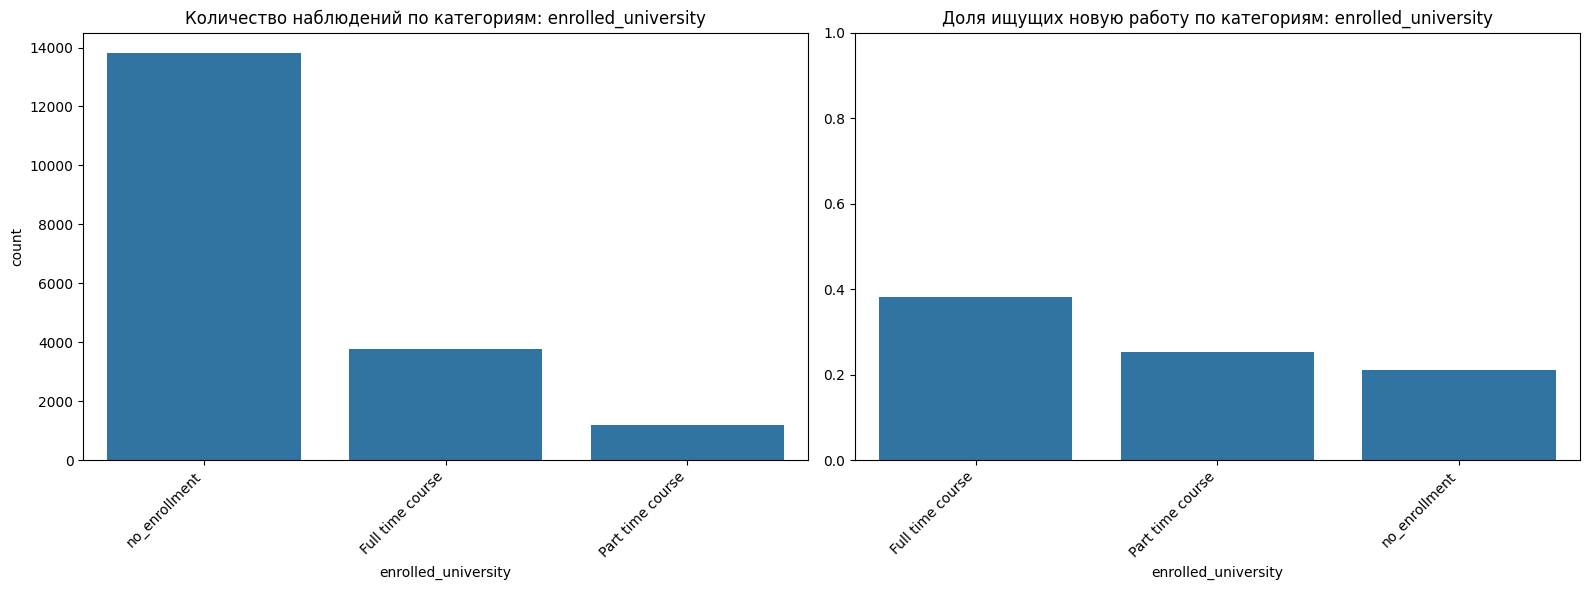

<Figure size 1200x600 with 0 Axes>

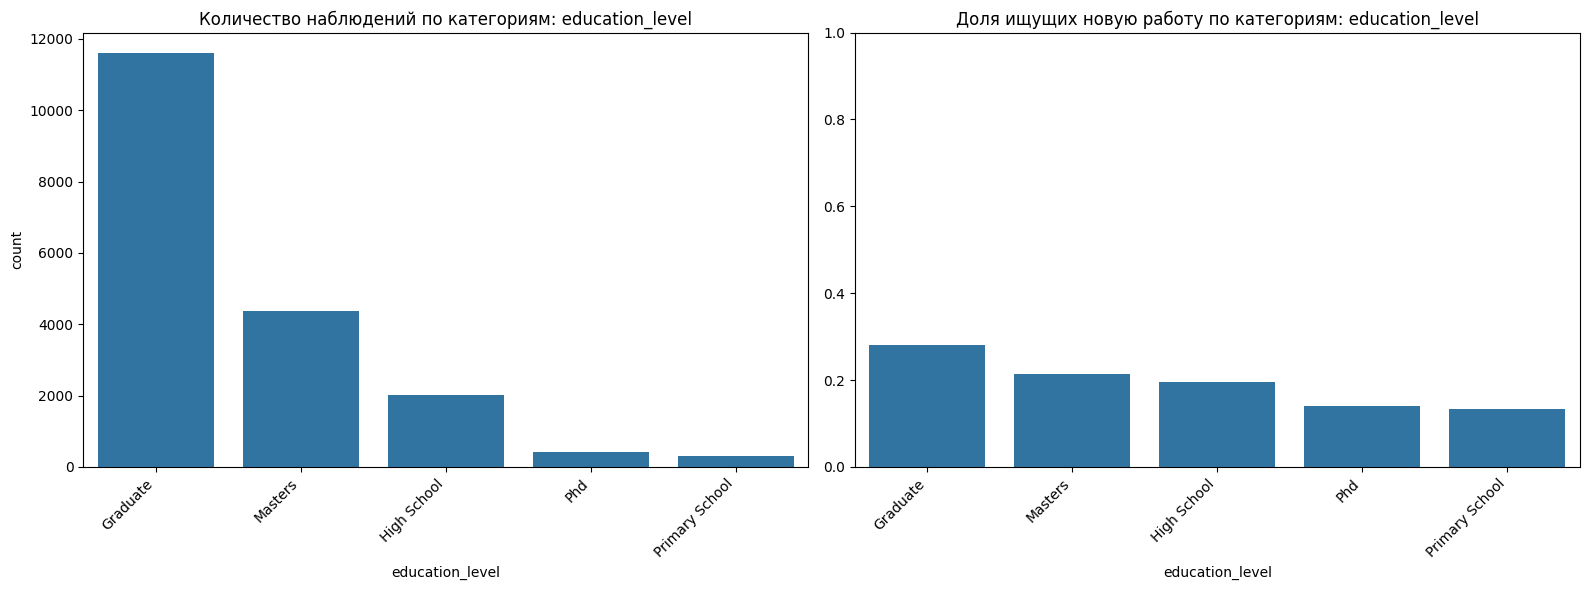

<Figure size 1200x600 with 0 Axes>

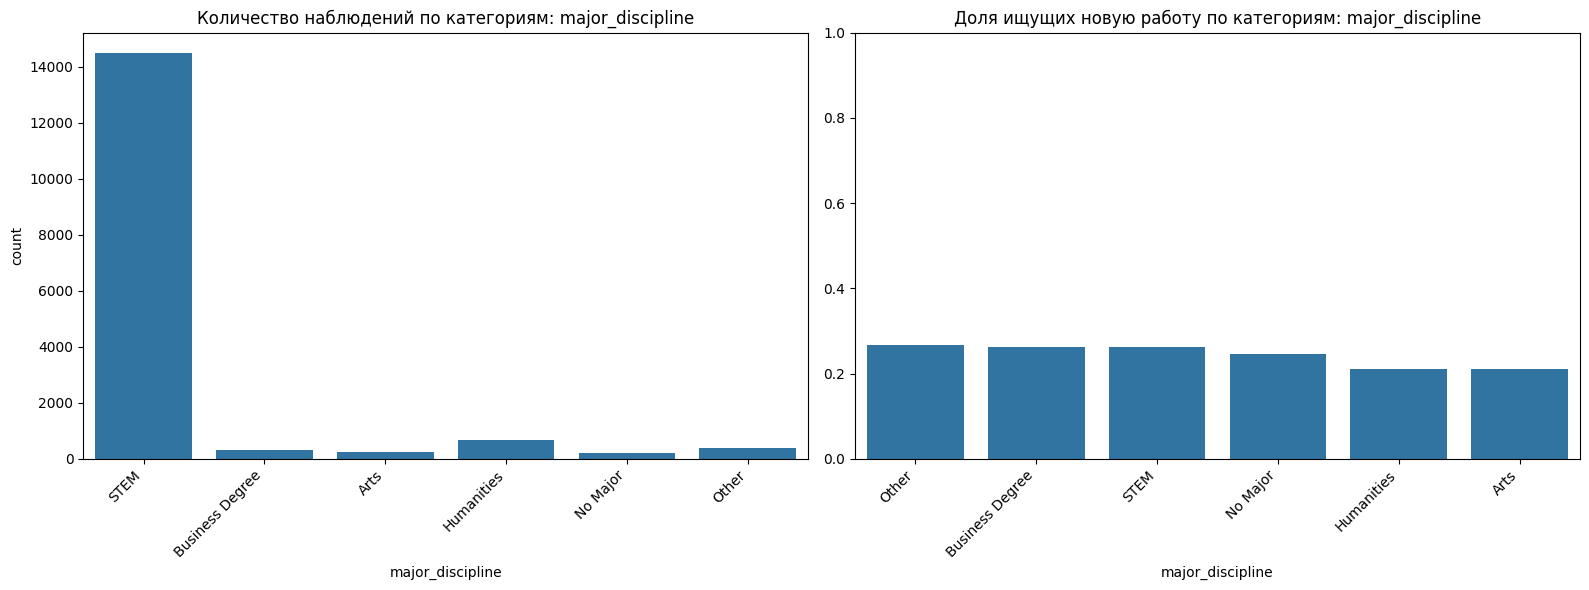

<Figure size 1200x600 with 0 Axes>

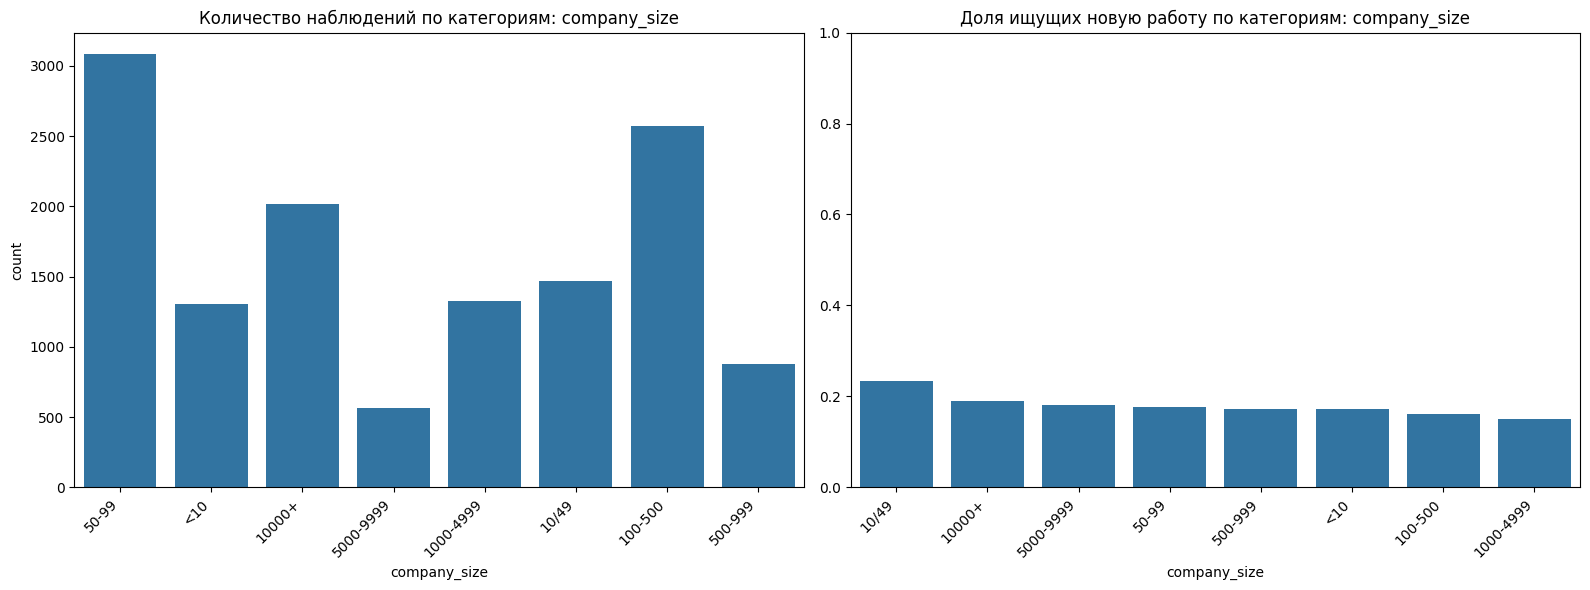

<Figure size 1200x600 with 0 Axes>

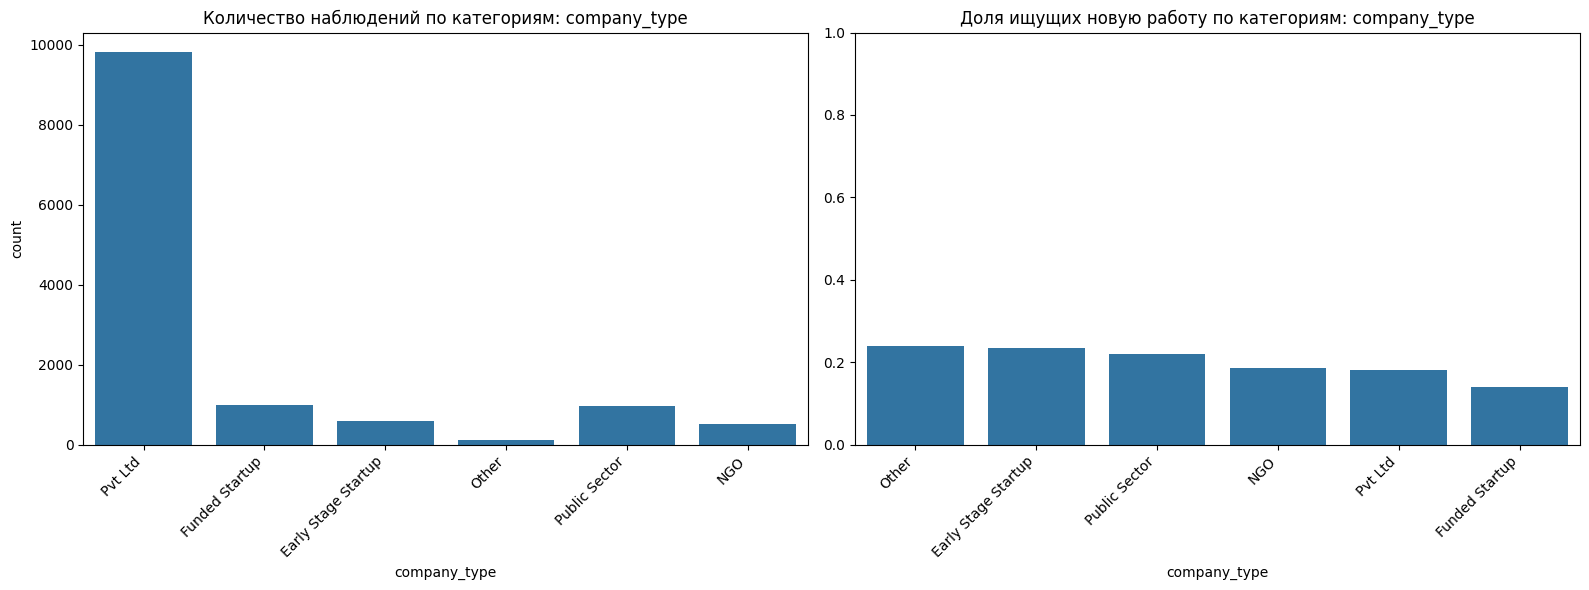

In [8]:
# Анализ категориальных признаков
categorical_features = ['gender', 'relevent_experience', 'enrolled_university', 
                        'education_level', 'major_discipline', 'company_size', 'company_type']

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    target_ratio = df.groupby(feature)['target'].mean().sort_values(ascending=False)
    
    # Создание подграфиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Количество наблюдений в каждой категории
    sns.countplot(x=feature, data=df, ax=ax1)
    ax1.set_title(f'Количество наблюдений по категориям: {feature}')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Доля ищущих новую работу в каждой категории
    sns.barplot(x=target_ratio.index, y=target_ratio.values, ax=ax2)
    ax2.set_title(f'Доля ищущих новую работу по категориям: {feature}')
    ax2.set_ylim(0, 1)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


Обучение модели: Логистическая регрессия
F1 Score: 0.6237
ROC AUC: 0.8081

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      2877
         1.0       0.53      0.76      0.62       955

    accuracy                           0.77      3832
   macro avg       0.72      0.77      0.73      3832
weighted avg       0.81      0.77      0.78      3832



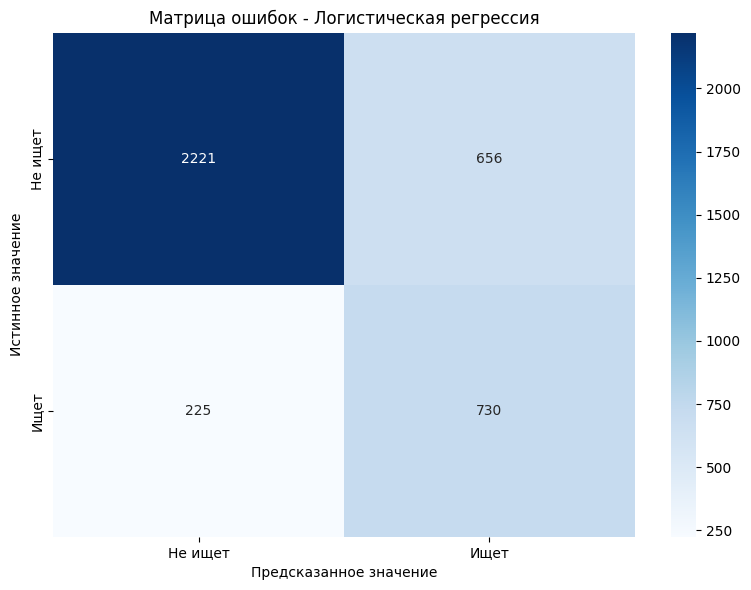

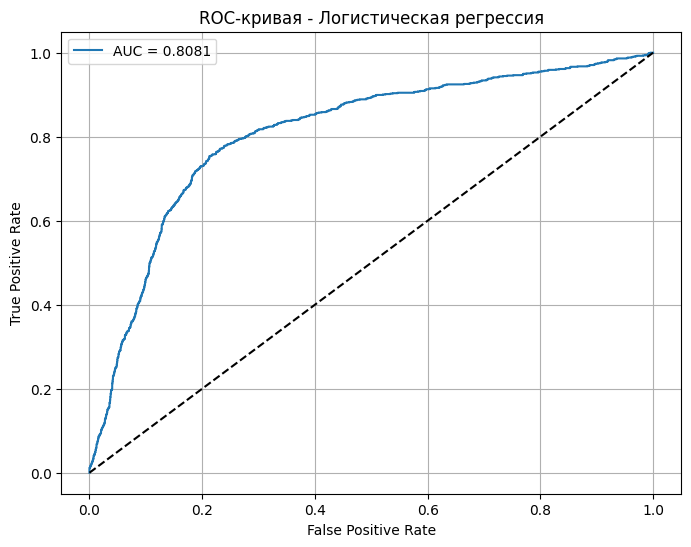


Обучение модели: Случайный лес
F1 Score: 0.5669
ROC AUC: 0.8021

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      2877
         1.0       0.57      0.56      0.57       955

    accuracy                           0.79      3832
   macro avg       0.71      0.71      0.71      3832
weighted avg       0.78      0.79      0.79      3832



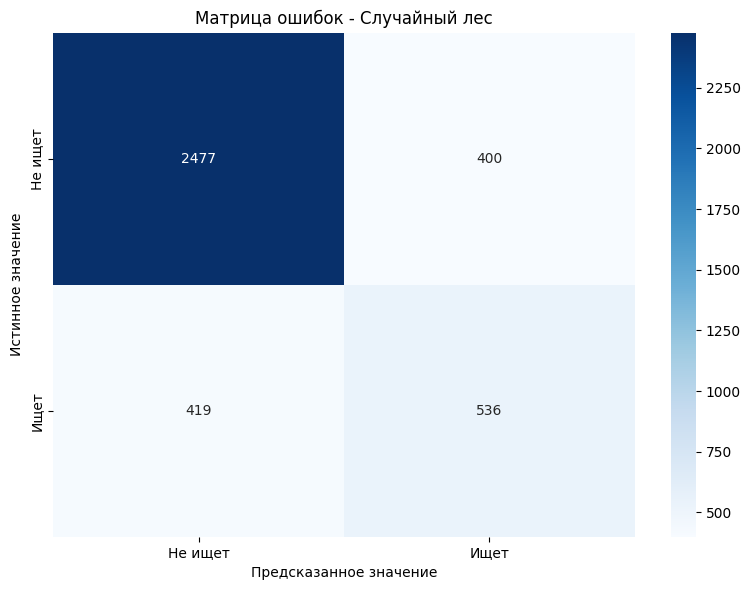

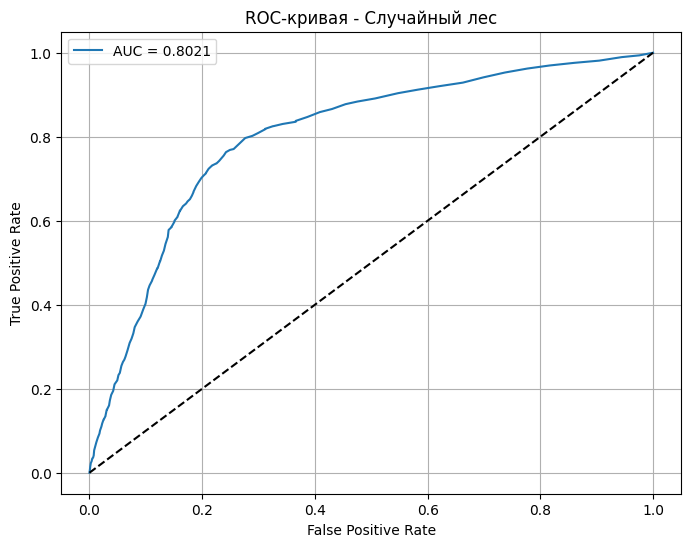


Обучение модели: Градиентный бустинг
F1 Score: 0.6345
ROC AUC: 0.8128

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      2877
         1.0       0.56      0.74      0.63       955

    accuracy                           0.79      3832
   macro avg       0.73      0.77      0.74      3832
weighted avg       0.82      0.79      0.80      3832



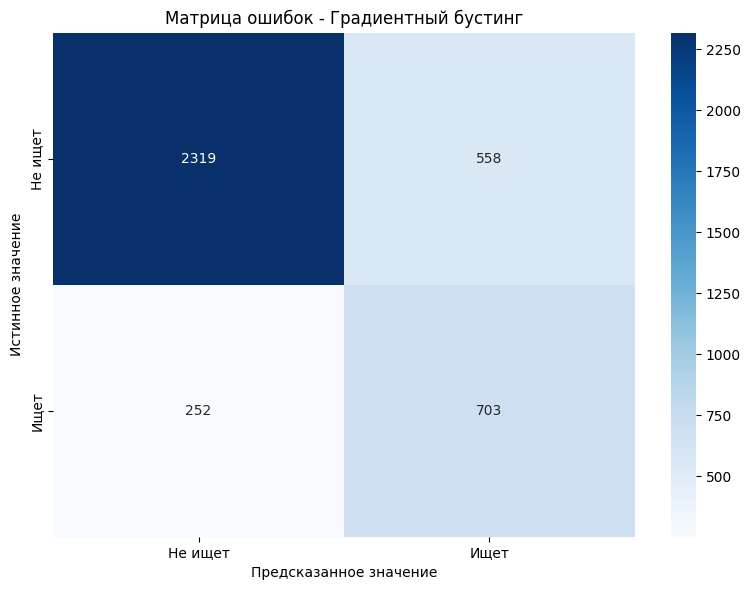

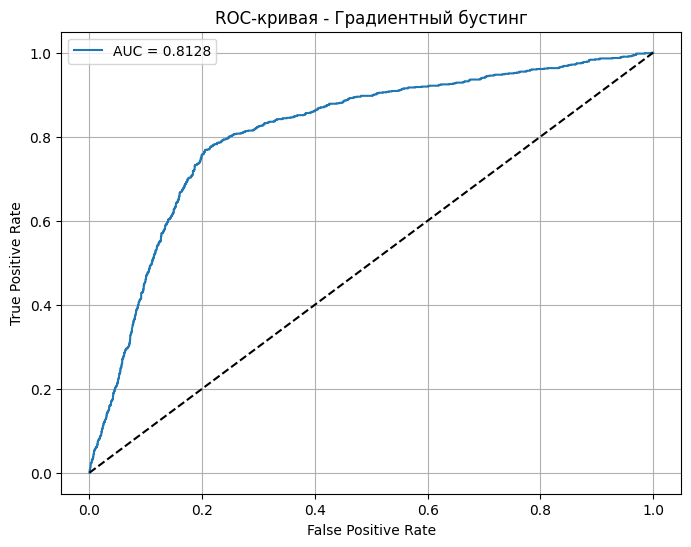


Обучение модели: XGBoost
F1 Score: 0.6153
ROC AUC: 0.8088

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      2877
         1.0       0.58      0.65      0.62       955

    accuracy                           0.80      3832
   macro avg       0.73      0.75      0.74      3832
weighted avg       0.81      0.80      0.80      3832



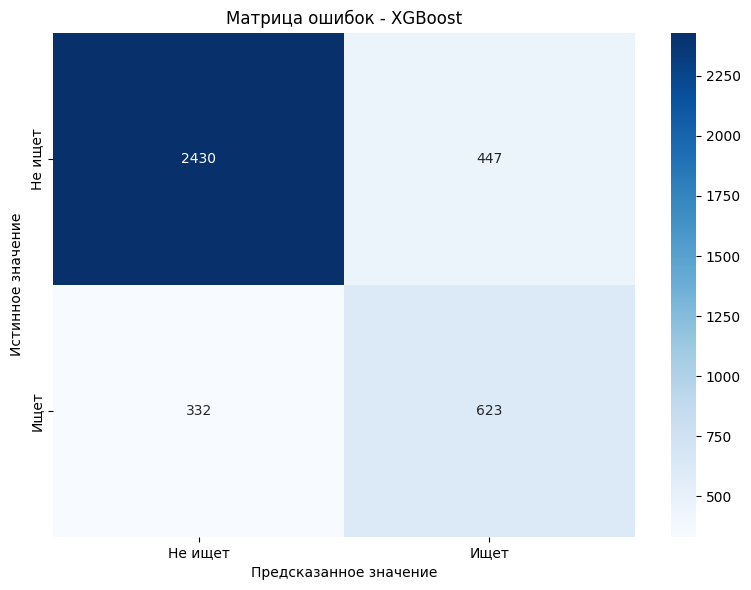

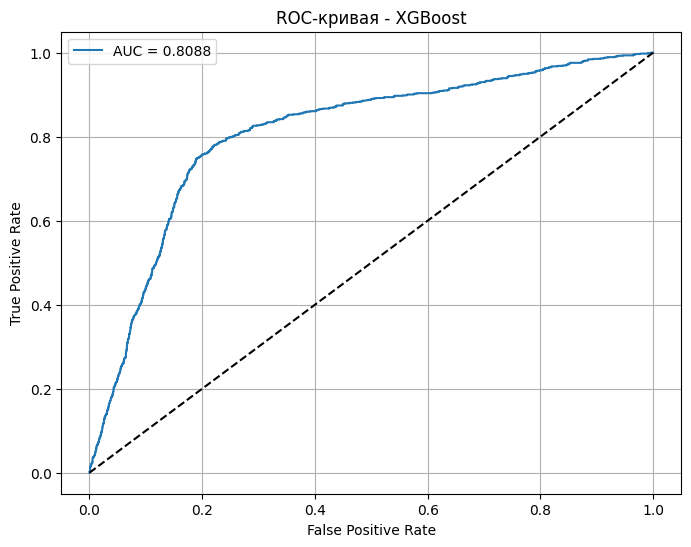

In [9]:
# Подготовка данных для моделирования
# Определение категориальных и числовых признаков
categorical_features = ['gender', 'relevent_experience', 'enrolled_university', 
                       'education_level', 'major_discipline', 'company_size', 
                       'company_type', 'city']
numeric_features = ['city_development_index', 'training_hours', 'experience', 'last_new_job']

# Разделение данных на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание пайплайна для предобработки данных
# Предобработка категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Предобработка числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Объединение в один препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Создание пайплайнов для разных моделей
# Используем Pipeline из imblearn для поддержки SMOTE
models = {
    'Логистическая регрессия': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
    ]),
    'Случайный лес': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'Градиентный бустинг': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    'XGBoost': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
    ])
}

# Обучение и оценка моделей
results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Сохранение результатов
    results[name] = {
        'f1_score': f1,
        'roc_auc': roc_auc,
        'model': model
    }
    
    # Вывод метрик
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Не ищет', 'Ищет'],
               yticklabels=['Не ищет', 'Ищет'])
    plt.title(f'Матрица ошибок - {name}')
    plt.xlabel('Предсказанное значение')
    plt.ylabel('Истинное значение')
    plt.tight_layout()
    plt.show()
    
    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая - {name}')
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
# Выбор лучшей модели по F1-мере
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Оптимизация гиперпараметров для лучшей модели
# Упрощенная версия для демонстрации - уменьшим количество параметров
if best_model_name == 'Логистическая регрессия':
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    }
elif best_model_name == 'Случайный лес':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
elif best_model_name == 'Градиентный бустинг':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.2]
    }
else:  # XGBoost
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.2]
    }


Лучшая модель: Градиентный бустинг
F1 Score: 0.6345
ROC AUC: 0.8128



Лучшие гиперпараметры:
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}

Результаты после оптимизации:
F1 Score: 0.6345
ROC AUC: 0.8128

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      2877
         1.0       0.56      0.74      0.63       955

    accuracy                           0.79      3832
   macro avg       0.73      0.77      0.74      3832
weighted avg       0.82      0.79      0.80      3832



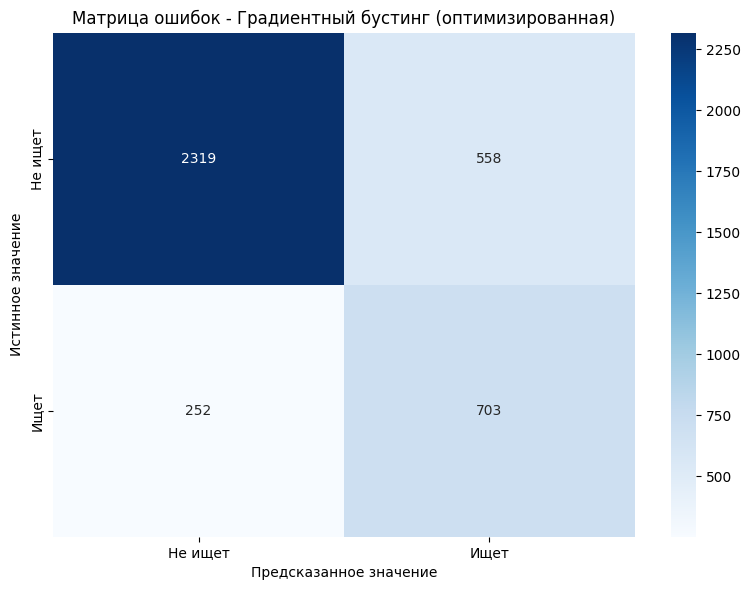

In [11]:
# Поиск оптимальных гиперпараметров с меньшим количеством наборов параметров
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(best_model, param_grid, scoring='f1', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("\nЛучшие гиперпараметры:")
print(grid_search.best_params_)

# Проверка оптимизированной модели
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)
y_proba_optimized = optimized_model.predict_proba(X_test)[:, 1]

f1_optimized = f1_score(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_proba_optimized)

print(f"\nРезультаты после оптимизации:")
print(f"F1 Score: {f1_optimized:.4f}")
print(f"ROC AUC: {roc_auc_optimized:.4f}")
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred_optimized))

# Матрица ошибок для оптимизированной модели
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Не ищет', 'Ищет'],
           yticklabels=['Не ищет', 'Ищет'])
plt.title(f'Матрица ошибок - {best_model_name} (оптимизированная)')
plt.xlabel('Предсказанное значение')
plt.ylabel('Истинное значение')
plt.tight_layout()
plt.show()


===== ВЫВОДЫ =====
1. Лучшая модель для прогнозирования смены работы: Градиентный бустинг
2. F1-мера после оптимизации: 0.6345
3. ROC AUC после оптимизации: 0.8128


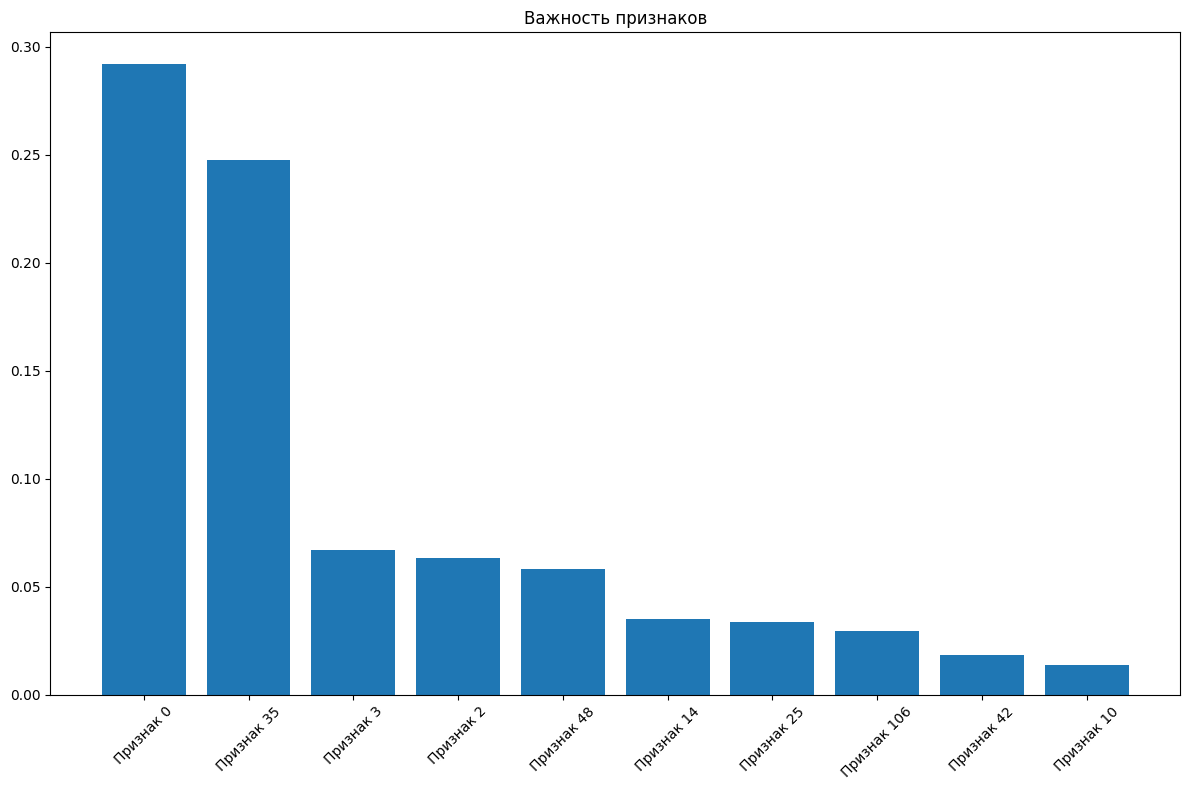


4. Ключевые факторы, влияющие на решение сменить работу:
   - Признак 0: 0.2920
   - Признак 35: 0.2473
   - Признак 3: 0.0668
   - Признак 2: 0.0631
   - Признак 48: 0.0584
5. Рекомендации для HR-отдела:
   - Уделять особое внимание кандидатам с наиболее значимыми характеристиками
   - Разработать целевые программы обучения для удержания определенных групп специалистов
   - Использовать предиктивную модель для раннего выявления потенциальных кандидатов на уход


In [12]:
# Выводы и рекомендации
print("\n===== ВЫВОДЫ =====")
print(f"1. Лучшая модель для прогнозирования смены работы: {best_model_name}")
print(f"2. F1-мера после оптимизации: {f1_optimized:.4f}")
print(f"3. ROC AUC после оптимизации: {roc_auc_optimized:.4f}")

# Анализ важности признаков
if best_model_name in ['Случайный лес', 'Градиентный бустинг', 'XGBoost']:
    # Применяем препроцессор к обучающим данным
    preprocessor_fit = optimized_model.named_steps['preprocessor']
    # Получаем важности признаков
    if hasattr(optimized_model.named_steps['classifier'], 'feature_importances_'):
        importances = optimized_model.named_steps['classifier'].feature_importances_
        
        # Создаем массив индексов от 0 до количества признаков-1
        indices = np.argsort(importances)[::-1]
        
        # Отображаем топ-10 признаков
        plt.figure(figsize=(12, 8))
        plt.title('Важность признаков')
        plt.bar(range(10), importances[indices[:10]])
        plt.xticks(range(10), [f'Признак {i}' for i in indices[:10]], rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\n4. Ключевые факторы, влияющие на решение сменить работу:")
        for i in range(5):
            print(f"   - Признак {indices[i]}: {importances[indices[i]]:.4f}")
    
print("5. Рекомендации для HR-отдела:")
print("   - Уделять особое внимание кандидатам с наиболее значимыми характеристиками")
print("   - Разработать целевые программы обучения для удержания определенных групп специалистов")
print("   - Использовать предиктивную модель для раннего выявления потенциальных кандидатов на уход")
